<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/AD002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Robust Random Cut Forest (RRCF) algorithm is an ensemble method for detecting outliers in streaming data. RRCF offers a number of features that many competing anomaly detection algorithms lack. Specifically, RRCF:

1. Is designed to handle streaming data.
2. Performs well on high-dimensional data.
3. Reduces the influence of irrelevant dimensions.
4. Gracefully handles duplicates and near-duplicates that could otherwise mask the presence of outliers.
5. Features an anomaly-scoring algorithm with a clear underlying statistical meaning.

This repository provides an open-source implementation of the RRCF algorithm and its core data structures for the purposes of facilitating experimentation and enabling future extensions of the RRCF algorithm.

In [1]:
import numpy as np


class RCTree:
    """
    Robust random cut tree data structure as described in:
    S. Guha, N. Mishra, G. Roy, & O. Schrijvers. Robust random cut forest based anomaly
    detection on streams, in Proceedings of the 33rd International conference on machine
    learning, New York, NY, 2016 (pp. 2712-2721).
    Parameters:
    -----------
    X: np.ndarray (n x d) (optional)
       Array containing n data points, each with dimension d.
       If no data provided, an empty tree is created.
    index_labels: sequence of length n (optional) (default=None)
                  Labels for data points provided in X.
                  Defaults to [0, 1, ... n-1].
    precision: float (optional) (default=9)
               Floating-point precision for distinguishing duplicate points.
    random_state: int, RandomState instance or None (optional) (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used by np.random.
    Attributes:
    -----------
    root: Branch or Leaf instance
          Pointer to root of tree.
    leaves: dict
            Dict containing pointers to all leaves in tree.
    ndim: int
          dimension of points in the tree
    Methods:
    --------
    insert_point: inserts a new point into the tree.
    forget_point: removes a point from the tree.
    disp: compute displacement associated with the removal of a leaf.
    codisp: compute collusive displacement associated with the removal of a leaf
            (anomaly score).
    map_leaves: traverses all nodes in the tree and executes a user-specified
                function on the leaves.
    map_branches: traverses all nodes in the tree and executes a user-specified
                  function on the branches.
    query: finds nearest point in tree.
    get_bbox: find bounding box of points under a given node.
    find_duplicate: finds duplicate points in the tree.
    Example:
    --------
    # Create RCTree
    >>> X = np.random.randn(100,2)
    >>> tree = RCTree(X)
    # Insert a point
    >>> x = np.random.randn(2)
    >>> tree.insert_point(x, index=100)
    # Compute collusive displacement of new point (anomaly score)
    >>> tree.codisp(100)
    # Remove point
    >>> tree.forget_point(100)
    """

    def __init__(self, X=None, index_labels=None, precision=9, 
                 random_state=None):
        # Random number generation with provided seed
        if isinstance(random_state, int):
            self.rng = np.random.RandomState(random_state)
        elif isinstance(random_state, np.random.RandomState):
            self.rng = random_state
        else:
            self.rng = np.random
        # Initialize dict for leaves
        self.leaves = {}
        # Initialize tree root
        self.root = None
        self.ndim = None
        if X is not None:
            # Round data to avoid sorting errors
            X = np.around(X, decimals=precision)
            # Initialize index labels, if they exist
            if index_labels is None:
                index_labels = np.arange(X.shape[0], dtype=int)
            self.index_labels = index_labels
            # Check for duplicates
            U, I, N = np.unique(X, return_inverse=True, return_counts=True,
                                axis=0)
            # If duplicates exist, take unique elements
            if N.max() > 1:
                n, d = U.shape
                X = U
            else:
                n, d = X.shape
                N = np.ones(n, dtype=np.int)
                I = None
            # Store dimension of dataset
            self.ndim = d
            # Set node above to None in case of bottom-up search
            self.u = None
            # Create RRC Tree
            S = np.ones(n, dtype=np.bool)
            self._mktree(X, S, N, I, parent=self)
            # Remove parent of root
            self.root.u = None
            # Count all leaves under each branch
            self._count_all_top_down(self.root)
            # Set bboxes of all branches
            self._get_bbox_top_down(self.root)

    def __repr__(self):
        depth = ""
        treestr = ""

        def print_push(char):
            nonlocal depth
            branch_str = ' {}  '.format(char)
            depth += branch_str

        def print_pop():
            nonlocal depth
            depth = depth[:-4]

        def print_tree(node):
            nonlocal depth
            nonlocal treestr
            if isinstance(node, Leaf):
                treestr += '({})\n'.format(node.i)
            elif isinstance(node, Branch):
                treestr += '{0}{1}\n'.format(chr(9472), '+')
                treestr += '{0} {1}{2}{2}'.format(depth, chr(9500), chr(9472))
                print_push(chr(9474))
                print_tree(node.l)
                print_pop()
                treestr += '{0} {1}{2}{2}'.format(depth, chr(9492), chr(9472))
                print_push(' ')
                print_tree(node.r)
                print_pop()

        print_tree(self.root)
        return treestr

    def _cut(self, X, S, parent=None, side='l'):
        # Find max and min over all d dimensions
        xmax = X[S].max(axis=0)
        xmin = X[S].min(axis=0)
        # Compute l
        l = xmax - xmin
        l /= l.sum()
        # Determine dimension to cut
        q = self.rng.choice(self.ndim, p=l)
        # Determine value for split
        p = self.rng.uniform(xmin[q], xmax[q])
        # Determine subset of points to left
        S1 = (X[:, q] <= p) & (S)
        # Determine subset of points to right
        S2 = (~S1) & (S)
        # Create new child node
        child = Branch(q=q, p=p, u=parent)
        # Link child node to parent
        if parent is not None:
            setattr(parent, side, child)
        return S1, S2, child

    def _mktree(self, X, S, N, I, parent=None, side='root', depth=0):
        # Increment depth as we traverse down
        depth += 1
        # Create a cut according to definition 1
        S1, S2, branch = self._cut(X, S, parent=parent, side=side)
        # If S1 does not contain an isolated point...
        if S1.sum() > 1:
            # Recursively construct tree on S1
            self._mktree(X, S1, N, I, parent=branch, side='l', depth=depth)
        # Otherwise...
        else:
            # Create a leaf node from isolated point
            i = np.asscalar(np.flatnonzero(S1))
            leaf = Leaf(i=i, d=depth, u=branch, x=X[i, :], n=N[i])
            # Link leaf node to parent
            branch.l = leaf
            # If duplicates exist...
            if I is not None:
                # Add a key in the leaves dict pointing to leaf for all duplicate indices
                J = np.flatnonzero(I == i)
                # Get index label
                J = self.index_labels[J]
                for j in J:
                    self.leaves[j] = leaf
            else:
                i = self.index_labels[i]
                self.leaves[i] = leaf
        # If S2 does not contain an isolated point...
        if S2.sum() > 1:
            # Recursively construct tree on S2
            self._mktree(X, S2, N, I, parent=branch, side='r', depth=depth)
        # Otherwise...
        else:
            # Create a leaf node from isolated point
            i = np.asscalar(np.flatnonzero(S2))
            leaf = Leaf(i=i, d=depth, u=branch, x=X[i, :], n=N[i])
            # Link leaf node to parent
            branch.r = leaf
            # If duplicates exist...
            if I is not None:
                # Add a key in the leaves dict pointing to leaf for all duplicate indices
                J = np.flatnonzero(I == i)
                # Get index label
                J = self.index_labels[J]
                for j in J:
                    self.leaves[j] = leaf
            else:
                i = self.index_labels[i]
                self.leaves[i] = leaf
        # Decrement depth as we traverse back up
        depth -= 1

    def map_leaves(self, node, op=(lambda x: None), *args, **kwargs):
        """
        Traverse tree recursively, calling operation given by op on leaves
        Parameters:
        -----------
        node: node in RCTree
        op: function to call on each leaf
        *args: positional arguments to op
        **kwargs: keyword arguments to op
        Returns:
        --------
        None
        Example:
        --------
        # Use map_leaves to print leaves in postorder
        >>> X = np.random.randn(10, 2)
        >>> tree = RCTree(X)
        >>> tree.map_leaves(tree.root, op=print)
        Leaf(5)
        Leaf(9)
        Leaf(4)
        Leaf(0)
        Leaf(6)
        Leaf(2)
        Leaf(3)
        Leaf(7)
        Leaf(1)
        Leaf(8)
        """
        if isinstance(node, Branch):
            if node.l:
                self.map_leaves(node.l, op=op, *args, **kwargs)
            if node.r:
                self.map_leaves(node.r, op=op, *args, **kwargs)
        else:
            op(node, *args, **kwargs)

    def map_branches(self, node, op=(lambda x: None), *args, **kwargs):
        """
        Traverse tree recursively, calling operation given by op on branches
        Parameters:
        -----------
        node: node in RCTree
        op: function to call on each branch
        *args: positional arguments to op
        **kwargs: keyword arguments to op
        Returns:
        --------
        None
        Example:
        --------
        # Use map_branches to collect all branches in a list
        >>> X = np.random.randn(10, 2)
        >>> tree = RCTree(X)
        >>> branches = []
        >>> tree.map_branches(tree.root, op=(lambda x, stack: stack.append(x)),
                            stack=branches)
        >>> branches
        [Branch(q=0, p=-0.53),
        Branch(q=0, p=-0.35),
        Branch(q=1, p=-0.67),
        Branch(q=0, p=-0.15),
        Branch(q=0, p=0.23),
        Branch(q=1, p=0.29),
        Branch(q=1, p=1.31),
        Branch(q=0, p=0.62),
        Branch(q=1, p=0.86)]
        """
        if isinstance(node, Branch):
            if node.l:
                self.map_branches(node.l, op=op, *args, **kwargs)
            if node.r:
                self.map_branches(node.r, op=op, *args, **kwargs)
            op(node, *args, **kwargs)

    def forget_point(self, index):
        """
        Delete leaf from tree
        Parameters:
        -----------
        index: (Hashable type)
               Index of leaf in tree
        Returns:
        --------
        leaf: Leaf instance
              Deleted leaf
        Example:
        --------
        # Create RCTree
        >>> tree = RCTree()
        # Insert a point
        >>> x = np.random.randn(2)
        >>> tree.insert_point(x, index=0)
        # Forget point
        >>> tree.forget_point(0)
        """
        try:
            # Get leaf from leaves dict
            leaf = self.leaves[index]
        except KeyError:
            raise KeyError('Leaf must be a key to self.leaves')
        # If duplicate points exist...
        if leaf.n > 1:
            # Simply decrement the number of points in the leaf and for all branches above
            self._update_leaf_count_upwards(leaf, inc=-1)
            return self.leaves.pop(index)
        # Weird cases here:
        # If leaf is the root...
        if leaf is self.root:
            self.root = None
            self.ndim = None
            return self.leaves.pop(index)
        # Find parent
        parent = leaf.u
        # Find sibling
        if leaf is parent.l:
            sibling = parent.r
        else:
            sibling = parent.l
        # If parent is the root...
        if parent is self.root:
            # Delete parent
            del parent
            # Set sibling as new root
            sibling.u = None
            self.root = sibling
            # Update depths
            if isinstance(sibling, Leaf):
                sibling.d = 0
            else:
                self.map_leaves(sibling, op=self._increment_depth, inc=-1)
            return self.leaves.pop(index)
        # Find grandparent
        grandparent = parent.u
        # Set parent of sibling to grandparent
        sibling.u = grandparent
        # Short-circuit grandparent to sibling
        if parent is grandparent.l:
            grandparent.l = sibling
        else:
            grandparent.r = sibling
        # Update depths
        parent = grandparent
        self.map_leaves(sibling, op=self._increment_depth, inc=-1)
        # Update leaf counts under each branch
        self._update_leaf_count_upwards(parent, inc=-1)
        # Update bounding boxes
        point = leaf.x
        self._relax_bbox_upwards(parent, point)
        return self.leaves.pop(index)

    def _update_leaf_count_upwards(self, node, inc=1):
        """
        Called after inserting or removing leaves. Updates the stored count of leaves
        beneath each branch (branch.n).
        """
        while node:
            node.n += inc
            node = node.u

    def insert_point(self, point, index, tolerance=None):
        """
        Inserts a point into the tree, creating a new leaf
        Parameters:
        -----------
        point: np.ndarray (1 x d)
        index: (Hashable type)
               Identifier for new leaf in tree
        tolerance: float
                   Tolerance for determining duplicate points
        Returns:
        --------
        leaf: Leaf
              New leaf in tree
        Example:
        --------
        # Create RCTree
        >>> tree = RCTree()
        # Insert a point
        >>> x = np.random.randn(2)
        >>> tree.insert_point(x, index=0)
        """
        if not isinstance(point, np.ndarray):
            point = np.asarray(point)
        point = point.ravel()
        if self.root is None:
            leaf = Leaf(x=point, i=index, d=0)
            self.root = leaf
            self.ndim = point.size
            self.leaves[index] = leaf
            return leaf
        # If leaves already exist in tree, check dimensions of point
        try:
            assert (point.size == self.ndim)
        except ValueError:
            raise ValueError(
                "Point must be same dimension as existing points in tree.")
        # Check for existing index in leaves dict
        try:
            assert (index not in self.leaves)
        except KeyError:
            raise KeyError("Index already exists in leaves dict.")
        # Check for duplicate points
        duplicate = self.find_duplicate(point, tolerance=tolerance)
        if duplicate:
            self._update_leaf_count_upwards(duplicate, inc=1)
            self.leaves[index] = duplicate
            return duplicate
        # If tree has points and point is not a duplicate, continue with main algorithm...
        node = self.root
        parent = node.u
        maxdepth = max([leaf.d for leaf in self.leaves.values()])
        depth = 0
        branch = None
        for _ in range(maxdepth + 1):
            bbox = node.b
            cut_dimension, cut = self._insert_point_cut(point, bbox)
            if cut <= bbox[0, cut_dimension]:
                leaf = Leaf(x=point, i=index, d=depth)
                branch = Branch(q=cut_dimension, p=cut, l=leaf, r=node,
                                n=(leaf.n + node.n))
                break
            elif cut >= bbox[-1, cut_dimension]:
                leaf = Leaf(x=point, i=index, d=depth)
                branch = Branch(q=cut_dimension, p=cut, l=node, r=leaf,
                                n=(leaf.n + node.n))
                break
            else:
                depth += 1
                if point[node.q] <= node.p:
                    parent = node
                    node = node.l
                    side = 'l'
                else:
                    parent = node
                    node = node.r
                    side = 'r'
        try:
            assert branch is not None
        except:
            raise AssertionError('Error with program logic: a cut was not found.')
        # Set parent of new leaf and old branch
        node.u = branch
        leaf.u = branch
        # Set parent of new branch
        branch.u = parent
        if parent is not None:
            # Set child of parent to new branch
            setattr(parent, side, branch)
        else:
            # If a new root was created, assign the attribute
            self.root = branch
        # Increment depths below branch
        self.map_leaves(branch, op=self._increment_depth, inc=1)
        # Increment leaf count above branch
        self._update_leaf_count_upwards(parent, inc=1)
        # Update bounding boxes
        self._tighten_bbox_upwards(branch)
        # Add leaf to leaves dict
        self.leaves[index] = leaf
        # Return inserted leaf for convenience
        return leaf

    def query(self, point, node=None):
        """
        Search for leaf nearest to point
        Parameters:
        -----------
        point: np.ndarray (1 x d)
               Point to search for
        node: Branch instance
              Defaults to root node
        Returns:
        --------
        nearest: Leaf
                 Leaf nearest to queried point in the tree
        Example:
        --------
        # Create RCTree
        >>> X = np.random.randn(10, 2)
        >>> tree = rrcf.RCTree(X)
        # Insert new point
        >>> new_point = np.array([4, 4])
        >>> tree.insert_point(new_point, index=10)
        # Query tree for point with added noise
        >>> tree.query(new_point + 1e-5)
        Leaf(10)
        """
        if not isinstance(point, np.ndarray):
            point = np.asarray(point)
        point = point.ravel()
        if node is None:
            node = self.root
        return self._query(point, node)

    def disp(self, leaf):
        """
        Compute displacement at leaf
        Parameters:
        -----------
        leaf: index of leaf or Leaf instance
        Returns:
        --------
        displacement: int
                      Displacement if leaf is removed
        Example:
        --------
        # Create RCTree
        >>> X = np.random.randn(100, 2)
        >>> tree = rrcf.RCTree(X)
        >>> new_point = np.array([4, 4])
        >>> tree.insert_point(new_point, index=100)
        # Compute displacement
        >>> tree.disp(100)
        12
        """
        if not isinstance(leaf, Leaf):
            try:
                leaf = self.leaves[leaf]
            except KeyError:
                raise KeyError(
                    'leaf must be a Leaf instance or key to self.leaves')
        # Handle case where leaf is root
        if leaf is self.root:
            return 0
        parent = leaf.u
        # Find sibling
        if leaf is parent.l:
            sibling = parent.r
        else:
            sibling = parent.l
        # Count number of nodes in sibling subtree
        displacement = sibling.n
        return displacement

    def codisp(self, leaf):
        """
        Compute collusive displacement at leaf
        Parameters:
        -----------
        leaf: index of leaf or Leaf instance
        Returns:
        --------
        codisplacement: float
                        Collusive displacement if leaf is removed.
        Example:
        --------
        # Create RCTree
        >>> X = np.random.randn(100, 2)
        >>> tree = rrcf.RCTree(X)
        >>> new_point = np.array([4, 4])
        >>> tree.insert_point(new_point, index=100)
        # Compute collusive displacement
        >>> tree.codisp(100)
        31.667
        """
        if not isinstance(leaf, Leaf):
            try:
                leaf = self.leaves[leaf]
            except KeyError:
                raise KeyError(
                    'leaf must be a Leaf instance or key to self.leaves')
        # Handle case where leaf is root
        if leaf is self.root:
            return 0
        node = leaf
        results = []
        for _ in range(node.d):
            parent = node.u
            if parent is None:
                break
            if node is parent.l:
                sibling = parent.r
            else:
                sibling = parent.l
            num_deleted = node.n
            displacement = sibling.n
            result = (displacement / num_deleted)
            results.append(result)
            node = parent
        co_displacement = max(results)
        return co_displacement

    def get_bbox(self, branch=None):
        """
        Compute bounding box of all points underneath a given branch.
        Parameters:
        -----------
        branch: Branch instance
                Starting branch. Defaults to root of tree.
        Returns:
        --------
        bbox: np.ndarray (2 x d)
              Bounding box of all points underneath branch
        Example:
        --------
        # Create RCTree and compute bbox
        >>> X = np.random.randn(10, 3)
        >>> tree = rrcf.RCTree(X)
        >>> tree.get_bbox()
        array([[-0.8600458 , -1.69756215, -1.16659065],
               [ 2.48455863,  1.02869042,  1.09414144]])
        """
        if branch is None:
            branch = self.root
        mins = np.full(self.ndim, np.inf)
        maxes = np.full(self.ndim, -np.inf)
        self.map_leaves(branch, op=self._get_bbox, mins=mins, maxes=maxes)
        bbox = np.vstack([mins, maxes])
        return bbox

    def find_duplicate(self, point, tolerance=None):
        """
        If point is a duplicate of existing point in the tree, return the leaf
        containing the point, else return None.
        Parameters:
        -----------
        point: np.ndarray (1 x d)
               Point to query in the tree.
        tolerance: float
                   Tolerance for determining whether or not point is a duplicate.
        Returns:
        --------
        duplicate: Leaf or None
                   If point is a duplicate, returns the leaf containing the point.
                   If point is not a duplicate, return None.
        Example:
        --------
        # Create RCTree
        >>> X = np.random.randn(10, 2)
        >>> tree = rrcf.RCTree(X)
        # Insert new point
        >>> new_point = np.array([4, 4])
        >>> tree.insert_point(new_point, index=10)
        # Search for duplicates
        >>> tree.find_duplicate((3, 3))
        >>> tree.find_duplicate((4, 4))
        Leaf(10)
        """
        nearest = self.query(point)
        if tolerance is None:
            if (nearest.x == point).all():
                return nearest
        else:
            if np.isclose(nearest.x, point, rtol=tolerance).all():
                return nearest
        return None

    def to_dict(self):
        """
        Serializes RCTree to a nested dict that can be written to disk or sent
        over a network (e.g. as json).
        Returns:
        --------
        obj: dict
             Nested dictionary representing all nodes in the RCTree.
        Example:
        --------
        # Create RCTree
        >>> X = np.random.randn(4, 3)
        >>> tree = rrcf.RCTree(X)
        # Write tree to dict
        >>> obj = tree.to_dict()
        >>> print(obj)
        # Write dict to file
        >>> import json
        >>> with open('tree.json', 'w') as outfile:
                json.dump(obj, outfile)
        """
        # Create empty dict
        obj = {}
        # Create dict to keep track of duplicates
        duplicates = {}
        for k, v in self.leaves.items():
            if isinstance(k, np.int64):
                duplicates.setdefault(v, []).append(int(k))
            else:
                duplicates.setdefault(v, []).append(k)
        # Serialize tree to dict
        self._serialize(self.root, obj, duplicates)
        # Return dict
        return obj

    def _serialize(self, node, obj, duplicates):
        """
        Recursively serializes tree into a nested dict.
        """
        if isinstance(node, Branch):
            obj['type'] = 'Branch'
            obj['q'] = int(node.q)
            obj['p'] = float(node.p)
            obj['n'] = int(node.n)
            obj['b'] = node.b.tolist()
            obj['l'] = {}
            obj['r'] = {}
            if node.l:
                self._serialize(node.l, obj['l'], duplicates)
            if node.r:
                self._serialize(node.r, obj['r'], duplicates)
        elif isinstance(node, Leaf):
            if isinstance(node.i, np.int64):
                i = int(node.i)
            else:
                i = node.i
            obj['type'] = 'Leaf'
            obj['i'] = i
            obj['x'] = node.x.tolist()
            obj['d'] = int(node.d)
            obj['n'] = int(node.n)
            obj['ixs'] = duplicates[node]
        else:
            raise TypeError('`node` must be Branch or Leaf instance')

    def load_dict(self, obj):
        """
        Deserializes a nested dict representing an RCTree and loads into the RCTree
        instance. Note that this will delete all data in the current RCTree and
        replace it with the loaded data.
        Parameters:
        -----------
        obj: dict
             Nested dictionary representing all nodes in the RCTree.
        Example:
        --------
        # Load dict (see to_dict method for more info)
        >>> import json
        >>> with open('tree.json', 'r') as infile:
                obj = json.load(infile)
        # Create empty RCTree and load data
        >>> tree = rrcf.RCTree()
        >>> tree.load_dict(obj)
        # View loaded data
        >>> print(tree)
        >>>
        ─+
        ├───+
        │   ├──(3)
        │   └───+
        │       ├──(2)
        │       └──(0)
        └──(1)
        """
        # Create anchor node
        anchor = Branch(q=None, p=None)
        # Create dictionary for restoring duplicates
        duplicates = {}
        # Deserialize json object
        self._deserialize(obj, anchor, duplicates)
        # Get root node
        root = anchor.l
        root.u = None
        # Fill in leaves dict
        leaves = {}
        for k, v in duplicates.items():
            for i in v:
                leaves[i] = k
        # Set root of tree to new root
        self.root = root
        self.leaves = leaves
        # Set number of dimensions based on first leaf
        self.ndim = len(next(iter(leaves.values())).x)

    def _deserialize(self, obj, node, duplicates, side='l'):
        """
        Recursively deserializes tree from a nested dict.
        """
        if obj['type'] == 'Branch':
            q = obj['q']
            p = obj['p']
            n = np.int64(obj['n'])
            b = np.asarray(obj['b'])
            branch = Branch(q=q, p=p, n=n, b=b, u=node)
            setattr(node, side, branch)
            if 'l' in obj:
                self._deserialize(obj['l'], branch, duplicates, side='l')
            if 'r' in obj:
                self._deserialize(obj['r'], branch, duplicates, side='r')
        elif obj['type'] == 'Leaf':
            i = obj['i']
            x = np.asarray(obj['x'])
            d = obj['d']
            n = np.int64(obj['n'])
            leaf = Leaf(i=i, x=x, d=d, n=n, u=node)
            setattr(node, side, leaf)
            duplicates[leaf] = obj['ixs']
        else:
            raise TypeError('`type` must be Branch or Leaf')

    @classmethod
    def from_dict(cls, obj):
        """
        Deserializes a nested dict representing an RCTree and creates a new
        RCTree instance from the loaded data.
        Parameters:
        -----------
        obj: dict
             Nested dictionary representing all nodes in the RCTree.
        Returns:
        --------
        newinstance: rrcf.RCTree
                     A new RCTree instance based on the loaded data.
        Example:
        --------
        # Load dict (see to_dict method for more info)
        >>> import json
        >>> with open('tree.json', 'r') as infile:
                obj = json.load(infile)
        # Create empty RCTree and load data
        >>> tree = rrcf.RCTree.from_dict(obj)
        # View loaded data
        >>> print(tree)
        >>>
        ─+
        ├───+
        │   ├──(3)
        │   └───+
        │       ├──(2)
        │       └──(0)
        └──(1)
        """
        newinstance = cls()
        newinstance.load_dict(obj)
        return newinstance

    def _lr_branch_bbox(self, node):
        """
        Compute bbox of node based on bboxes of node's children.
        """
        bbox = np.vstack([np.minimum(node.l.b[0, :], node.r.b[0, :]),
                          np.maximum(node.l.b[-1, :], node.r.b[-1, :])])
        return bbox

    def _get_bbox_top_down(self, node):
        """
        Recursively compute bboxes of all branches from root to leaves.
        """
        if isinstance(node, Branch):
            if node.l:
                self._get_bbox_top_down(node.l)
            if node.r:
                self._get_bbox_top_down(node.r)
            bbox = self._lr_branch_bbox(node)
            node.b = bbox

    def _count_all_top_down(self, node):
        """
        Recursively compute number of leaves below each branch from
        root to leaves.
        """
        if isinstance(node, Branch):
            if node.l:
                self._count_all_top_down(node.l)
            if node.r:
                self._count_all_top_down(node.r)
            node.n = node.l.n + node.r.n

    def _count_leaves(self, node):
        """
        Count leaves underneath a single node.
        """
        num_leaves = np.array(0, dtype=np.int64)
        self.map_leaves(node, op=self._accumulate, accumulator=num_leaves)
        num_leaves = np.asscalar(num_leaves)
        return num_leaves

    def _query(self, point, node):
        """
        Recursively search for the nearest leaf to a given point.
        """
        if isinstance(node, Leaf):
            return node
        else:
            if point[node.q] <= node.p:
                return self._query(point, node.l)
            else:
                return self._query(point, node.r)

    def _increment_depth(self, x, inc=1):
        """
        Primitive function for incrementing the depth attribute of a leaf.
        """
        x.d += (inc)

    def _accumulate(self, x, accumulator):
        """
        Primitive function for helping to count the number of points in a subtree.
        """
        accumulator += (x.n)

    def _get_nodes(self, x, stack):
        """
        Primitive function for listing all leaves in a subtree.
        """
        stack.append(x)

    def _get_bbox(self, x, mins, maxes):
        """
        Primitive function for computing the bbox of a point.
        """
        lt = (x.x < mins)
        gt = (x.x > maxes)
        mins[lt] = x.x[lt]
        maxes[gt] = x.x[gt]

    def _tighten_bbox_upwards(self, node):
        """
        Called when new point is inserted. Expands bbox of all nodes above new point
        if point is outside the existing bbox.
        """
        bbox = self._lr_branch_bbox(node)
        node.b = bbox
        node = node.u
        while node:
            lt = (bbox[0, :] < node.b[0, :])
            gt = (bbox[-1, :] > node.b[-1, :])
            lt_any = lt.any()
            gt_any = gt.any()
            if lt_any or gt_any:
                if lt_any:
                    node.b[0, :][lt] = bbox[0, :][lt]
                if gt_any:
                    node.b[-1, :][gt] = bbox[-1, :][gt]
            else:
                break
            node = node.u

    def _relax_bbox_upwards(self, node, point):
        """
        Called when point is deleted. Contracts bbox of all nodes above deleted point
        if the deleted point defined the boundary of the bbox.
        """
        while node:
            bbox = self._lr_branch_bbox(node)
            if not ((node.b[0, :] == point) | (node.b[-1, :] == point)).any():
                break
            node.b[0, :] = bbox[0, :]
            node.b[-1, :] = bbox[-1, :]
            node = node.u

    def _insert_point_cut(self, point, bbox):
        """
        Generates the cut dimension and cut value based on the InsertPoint algorithm.
        Parameters:
        -----------
        point: np.ndarray (1 x d)
               New point to be inserted.
        bbox: np.ndarray(2 x d)
              Bounding box of point set S.
        Returns:
        --------
        cut_dimension: int
                       Dimension to cut over.
        cut: float
             Value of cut.
        Example:
        --------
        # Generate cut dimension and cut value
        >>> _insert_point_cut(x_inital, bbox)
        (0, 0.9758881798109296)
        """
        # Generate the bounding box
        bbox_hat = np.empty(bbox.shape)
        # Update the bounding box based on the internal point
        bbox_hat[0, :] = np.minimum(bbox[0, :], point)
        bbox_hat[-1, :] = np.maximum(bbox[-1, :], point)
        b_span = bbox_hat[-1, :] - bbox_hat[0, :]
        b_range = b_span.sum()
        r = self.rng.uniform(0, b_range)
        span_sum = np.cumsum(b_span)
        cut_dimension = np.inf
        for j in range(len(span_sum)):
            if span_sum[j] >= r:
                cut_dimension = j
                break
        if not np.isfinite(cut_dimension):
            raise ValueError("Cut dimension is not finite.")
        cut = bbox_hat[0, cut_dimension] + span_sum[cut_dimension] - r
        return cut_dimension, cut


class Branch:
    """
    Branch of RCTree containing two children and at most one parent.
    Attributes:
    -----------
    q: Dimension of cut
    p: Value of cut
    l: Pointer to left child
    r: Pointer to right child
    u: Pointer to parent
    n: Number of leaves under branch
    b: Bounding box of points under branch (2 x d)
    """
    __slots__ = ['q', 'p', 'l', 'r', 'u', 'n', 'b']

    def __init__(self, q, p, l=None, r=None, u=None, n=0, b=None):
        self.l = l
        self.r = r
        self.u = u
        self.q = q
        self.p = p
        self.n = n
        self.b = b

    def __repr__(self):
        return "Branch(q={}, p={:.2f})".format(self.q, self.p)


class Leaf:
    """
    Leaf of RCTree containing no children and at most one parent.
    Attributes:
    -----------
    i: Index of leaf (user-specified)
    d: Depth of leaf
    u: Pointer to parent
    x: Original point (1 x d)
    n: Number of points in leaf (1 if no duplicates)
    b: Bounding box of point (1 x d)
    """
    __slots__ = ['i', 'd', 'u', 'x', 'n', 'b']

    def __init__(self, i, d=None, u=None, x=None, n=1):
        self.u = u
        self.i = i
        self.d = d
        self.x = x
        self.n = n
        self.b = x.reshape(1, -1)

    def __repr__(self):
        return "Leaf({0})".format(self.i)

In [2]:
from collections import deque
import numpy as np


def shingle(sequence, size):
    """
    Generator that yields shingles (a rolling window) of a given size.
    Parameters
    ----------
    sequence : iterable
               Sequence to be shingled
    size : int
           size of shingle (window)
    """
    iterator = iter(sequence)
    init = (next(iterator) for _ in range(size))
    window = deque(init, maxlen=size)
    if len(window) < size:
        raise IndexError('Sequence smaller than window size')
    yield np.asarray(window)
    for elem in iterator:
        window.append(elem)
        yield np.asarray(window)

Creating the tree

In [3]:
import numpy as np
#import rrcf

# Instantiate a random cut tree from a point set (n x d)
X = np.random.randn(100, 2)
#tree = rrcf.RCTree(X)
tree = RCTree(X)

# Instantiate an empty random cut tree
#tree = rrcf.RCTree()
tree = RCTree()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/loca

Inserting points

In [4]:
#tree = rrcf.RCTree()
tree = RCTree()

for i in range(6):
    x = np.random.randn(2)
    tree.insert_point(x, index=i)

In [5]:
print(tree)

─+
 ├───+
 │   ├───+
 │   │   ├───+
 │   │   │   ├───+
 │   │   │   │   ├──(4)
 │   │   │   │   └──(2)
 │   │   │   └──(5)
 │   │   └──(3)
 │   └──(0)
 └──(1)



Deleting points

In [6]:
tree.forget_point(2)

Leaf(2)

In [7]:
print(tree)

─+
 ├───+
 │   ├───+
 │   │   ├───+
 │   │   │   ├──(4)
 │   │   │   └──(5)
 │   │   └──(3)
 │   └──(0)
 └──(1)



Anomaly score

The likelihood that a point is an outlier is measured by its collusive displacement (CoDisp): 

If including a new point significantly changes the model complexity (i.e. bit depth), then that point is more likely to be an outlier.



In [8]:
# Seed tree with zero-mean, normally distributed data
X = np.random.randn(100,2)
#tree = rrcf.RCTree(X)
tree = RCTree(X)

# Generate an inlier and outlier point
inlier = np.array([0, 0])
outlier = np.array([4, 4])

# Insert into tree
tree.insert_point(inlier, index='inlier')
tree.insert_point(outlier, index='outlier')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/loca

Leaf(outlier)

In [9]:
print(tree)

─+
 ├──(66)
 └───+
     ├───+
     │   ├───+
     │   │   ├───+
     │   │   │   ├───+
     │   │   │   │   ├───+
     │   │   │   │   │   ├──(68)
     │   │   │   │   │   └──(14)
     │   │   │   │   └──(27)
     │   │   │   └──(63)
     │   │   └───+
     │   │       ├───+
     │   │       │   ├───+
     │   │       │   │   ├───+
     │   │       │   │   │   ├──(5)
     │   │       │   │   │   └───+
     │   │       │   │   │       ├──(74)
     │   │       │   │   │       └──(46)
     │   │       │   │   └───+
     │   │       │   │       ├──(23)
     │   │       │   │       └──(76)
     │   │       │   └───+
     │   │       │       ├───+
     │   │       │       │   ├──(24)
     │   │       │       │   └───+
     │   │       │       │       ├──(55)
     │   │       │       │       └──(39)
     │   │       │       └──(84)
     │   │       └───+
     │   │           ├───+
     │   │           │   ├──(16)
     │   │           │   └───+
     │   │           │       ├──(94)
     │   │  

In [10]:
print("outlier\n",outlier)

print("inlier\n",inlier)


outlier
 [4 4]
inlier
 [0 0]


In [11]:
print(tree.codisp('inlier'))


print(tree.codisp('outlier'))

1.0
17.5


Batch anomaly detection


This example shows how a robust random cut forest can be used to detect outliers in a batch setting. 
Outliers correspond to large CoDisp.

In [12]:
import numpy as np
import pandas as pd
#import rrcf

# Set sample parameters
np.random.seed(0)
n = 2010
d = 3

# Generate data
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)

# Set forest parameters
num_trees = 100
tree_size = 256
sample_size_range = (n // tree_size, tree_size)

# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    # Add sampled trees to forest
    trees = [RCTree(X[ix], index_labels=ix)
             for ix in ixs]
    #trees = [rrcf.RCTree(X[ix], index_labels=ix)
    #         for ix in ixs]
    forest.extend(trees)

# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                       for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/loca

In [13]:
print(tree.leaves)

{1495: Leaf(135), 1004: Leaf(105), 1129: Leaf(211), 1815: Leaf(169), 1730: Leaf(133), 1925: Leaf(247), 1667: Leaf(49), 1843: Leaf(2), 1151: Leaf(193), 1310: Leaf(217), 1357: Leaf(138), 1240: Leaf(35), 1561: Leaf(131), 1853: Leaf(74), 1848: Leaf(18), 1088: Leaf(70), 1828: Leaf(239), 1689: Leaf(149), 1641: Leaf(159), 1177: Leaf(37), 1399: Leaf(41), 1949: Leaf(69), 1307: Leaf(249), 1008: Leaf(6), 1300: Leaf(54), 1048: Leaf(8), 1297: Leaf(185), 1803: Leaf(158), 1077: Leaf(236), 1553: Leaf(110), 1844: Leaf(155), 1550: Leaf(101), 1095: Leaf(92), 1056: Leaf(163), 1555: Leaf(57), 1104: Leaf(40), 1305: Leaf(55), 1786: Leaf(104), 1864: Leaf(67), 1934: Leaf(223), 1329: Leaf(162), 1449: Leaf(246), 1539: Leaf(179), 1646: Leaf(171), 1773: Leaf(107), 1325: Leaf(73), 1628: Leaf(91), 1249: Leaf(142), 1530: Leaf(47), 1681: Leaf(20), 1820: Leaf(44), 1961: Leaf(42), 1425: Leaf(123), 1959: Leaf(43), 1201: Leaf(183), 1839: Leaf(198), 1841: Leaf(220), 1872: Leaf(130), 1859: Leaf(39), 1596: Leaf(129), 1965: L

In [14]:
print(pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves}))
print(index)
print(codisp)
print(codisp.index.values)

1495     3.000000
1004     3.000000
1129     3.000000
1815     3.000000
1730     3.000000
          ...    
847     10.272727
995     10.272727
469     10.272727
371     10.272727
139     10.272727
Length: 256, dtype: float64
[14. 14. 15. ... 15. 13. 14.]
1495     3.000000
1004     3.000000
1129     3.000000
1815     3.000000
1730     3.000000
          ...    
847     10.272727
995     10.272727
469     10.272727
371     10.272727
139     10.272727
Length: 256, dtype: float64
[1495 1004 1129 1815 1730 1925 1667 1843 1151 1310 1357 1240 1561 1853
 1848 1088 1828 1689 1641 1177 1399 1949 1307 1008 1300 1048 1297 1803
 1077 1553 1844 1550 1095 1056 1555 1104 1305 1786 1864 1934 1329 1449
 1539 1646 1773 1325 1628 1249 1530 1681 1820 1961 1425 1959 1201 1839
 1841 1872 1859 1596 1965 1269 1429 1422 1242 1944 1656 1973 1988 1411
 1874 1903 1528 1038 1003 1195 1587 1908 1206 1145 1497 1447 1969 1102
 1397 1474 1917 1110 1702 1116 1431 1817 1827 1166 1715 1865 1346 1893
 1486 1692 1073 1933 

Text(0.5, 0.92, 'CoDisp above 99.5th percentile')

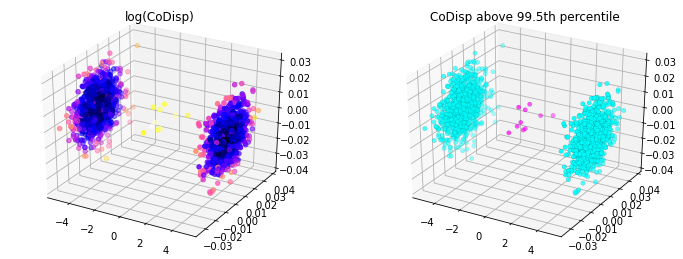

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import colors

#threshold = avg_codisp.nlargest(n=10).min()
threshold = avg_codisp.nlargest(n=10).min()

fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2],
                c=np.log(avg_codisp.sort_index().values),
                cmap='gnuplot2')
plt.title('log(CoDisp)')
ax = fig.add_subplot(122, projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2],
                linewidths=0.1, edgecolors='k',
                c=(avg_codisp >= threshold).astype(float),
                cmap='cool')
plt.title('CoDisp above 99.5th percentile')

Streaming anomaly detection

This example shows how the algorithm can be used to detect anomalies in streaming time series data.

In [16]:
import numpy as np
#import rrcf

# Generate data
n = 730
A = 50
center = 100
phi = 30
T = 2*np.pi/100
t = np.arange(n)
sin = A*np.sin(T*t-phi*T) + center
sin[235:255] = 80

# Set tree parameters
num_trees = 40
shingle_size = 4
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    #tree = rrcf.RCTree()
    tree = RCTree()
    forest.append(tree)
    
# Use the "shingle" generator to create rolling window
#points = rrcf.shingle(sin, size=shingle_size)
points = shingle(sin, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

Text(0.5, 1.0, 'Sine wave with injected anomaly (red) and anomaly score (blue)')

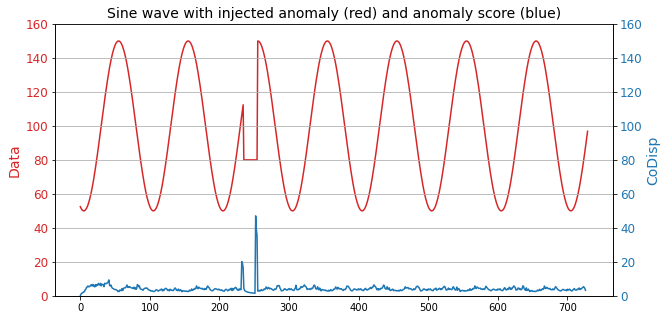

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(sin, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,160)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)

Comparison with other outlier detection methods

In this example, we compare RRCF with the outlier detection methods included in scikit-learn. 

We use the same test datasets used in the scikit-learn outlier detection documentation.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/loca

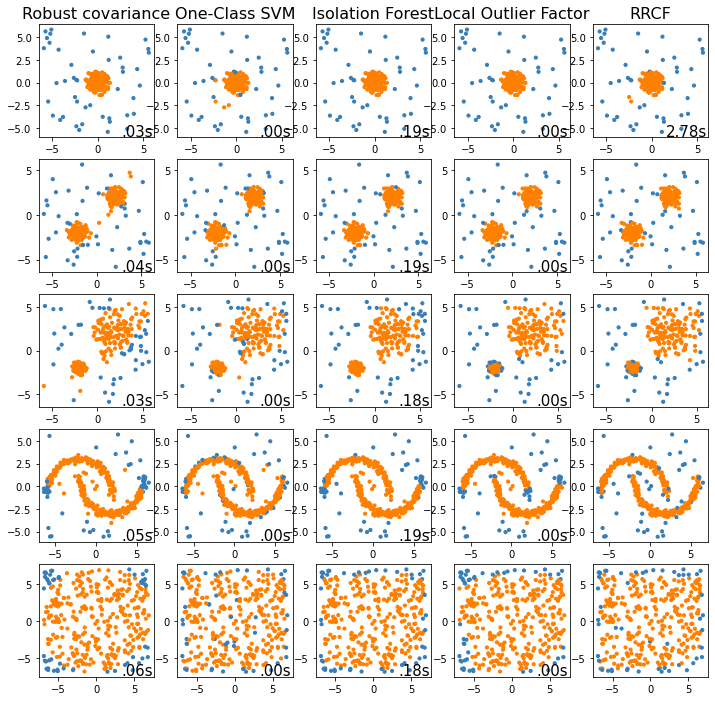

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_blobs
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import time


rng = np.random.RandomState(42)


# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers



# Outlier detectors from sklean plot
anomaly_algorithms = [
    ("Robust covariance",
     EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM",
     svm.OneClassSVM(nu=outliers_fraction,
                     kernel="rbf",
                     gamma=0.1)),
    ("Isolation Forest",
     IsolationForest(contamination=outliers_fraction)),
#    ("Isolation Forest",
#     IsolationForest(contamination=outliers_fraction,
#                     behaviour='new')),
    ("Local Outlier Factor",
     LocalOutlierFactor(n_neighbors=35,
                        contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0,
                    n_samples=n_inliers,
                    n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]],
               cluster_std=0.5,**blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]],
               cluster_std=[0.5, 0.5],**blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]],
               cluster_std=[1.5, .3],**blobs_params)[0],
    4. * (make_moons(n_samples=n_samples,
                     noise=.05, random_state=0)[0]
                     - np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2)
           - 0.5)]

# Add outliers to the data sets
outliers = []  # record keeping
data = []
for i in datasets:
    out = rng.uniform(low=-6, high=6,
                      size=(n_outliers, 2))
    outliers.append(out)
    data.append(np.concatenate([i, out], axis=0))

# Set forest params
avg_codisp = []
num_trees  = 100
tree_size = 256
plot_num = 1

fig = plt.figure(1, figsize=(12, 12))

for d in range(len(data)):
    forest = []
    n = len(data[d])
    tr1 = time.time()
    while len(forest) < num_trees:
        # Select random subsets of points uniformly from point set
        ixs = np.random.choice(n,
                               size=(n // tree_size, tree_size),
                               replace=False)
        # Add sampled trees to forest
        #trees = [rrcf.RCTree(data[d][ix],
        #                     index_labels=ix) for ix in ixs]
        trees = [RCTree(data[d][ix],
                             index_labels=ix) for ix in ixs]
        forest.extend(trees)

    # Compute average CoDisp
    avg_codisp_d = pd.Series(0.0, index=np.arange(n))
    index = np.zeros(n)
    for tree in forest:
        codisp = pd.Series({leaf : tree.codisp(leaf)
                            for leaf in tree.leaves})
        avg_codisp_d[codisp.index] += codisp
        np.add.at(index, codisp.index.values, 1)
    avg_codisp_d /= index

    avg_codisp.append(avg_codisp_d)
    tr2 = time.time()


    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(data[d])
        t1 = time.time()
        plt.subplot(5, len(anomaly_algorithms) + 1,
                    plot_num)
        if d == 0:
            plt.title(name, size=16)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(data[d])
        else:
            y_pred = (algorithm.fit(data[d])
                      .predict(data[d]))

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(data[d][:, 0], data[d][:, 1], s=10,
                    color=colors[(y_pred + 1) // 2])
        plt.text(.99, .01,
                 ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

    plt.subplot(5, len(anomaly_algorithms) + 1, plot_num)
    avg_cod = avg_codisp[-1]
    mask = np.percentile(avg_cod, 85)
    avg_cod[avg_cod < mask] = 1
    avg_cod[avg_cod > mask] = 0
    c = ['#377eb8' if i == 0 else '#ff7f00'
         for i in avg_cod]
    plt.scatter(data[d][:,0], data[d][:,1], s=10, c=c)
    if d == 0:
        plt.title("RRCF", size=16)

        plt.text(.99, .01,
                 ('%.2fs' % (tr2 - tr1)).lstrip('0'),
                  transform=plt.gca().transAxes, size=15,
                  horizontalalignment='right')
    plot_num += 1